In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
store_sales = pd.read_csv(
    'store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

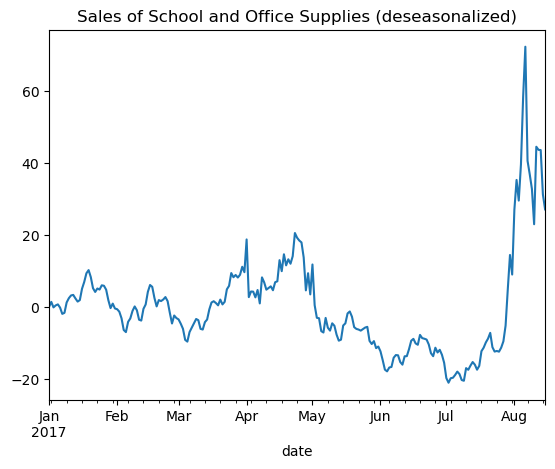

In [3]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");